# **Model Comparison** (nested models)

---

Let's define our Baseline:

We will make a median-based baseline among AI-ML job titles and top20 countries (in frequency terms)

In [35]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')

In [36]:
# The MedianBaselineModel class is defined here. This class represents a baseline model 
# that uses median values for predictions and follows the scikit-learn estimator interface.
class MedianBaselineModel(BaseEstimator, RegressorMixin):
    
    def fit(self, X, y):
        # Concatenating features and target variable and then calculating the median
        self.baseline_model = pd.concat([X, y], axis=1)
        self.baseline_model = self.baseline_model.groupby(baseline_features).median().reset_index()
        return self
    
    def predict(self, X):
        # Merging test data with the baseline model to get predictions
        predictions = X.merge(self.baseline_model, on=baseline_features, how='left')
        return predictions['Annual_salary'].fillna(predictions['Annual_salary'].median())

- Data Preprocessing

In [37]:
# Reading the training and testing datasets
train_df = pd.read_csv('../../output/clean_train_df.csv')
test_df = pd.read_csv('../../output/clean_test_df.csv')

# Upon exploration in MLR results, we found that the following columns are adding noise to the model
# as they correspond to values mainly from USA with non-sense relationship mainly Work_experience - Annual_salary
# Hence, we will remove them from the baseline model
train_df.drop([2153,359, 281, 297, 432, 601, 309, 239, 409, 454], inplace=True)
test_df.drop(538, inplace=True)

# Defining the features to be used in the baseline model
top20countries = ['Country_USA', 'Country_Germany', 'Country_UK & Northern Ireland', 'Country_Canada', 'Country_France', 'Country_India',
       'Country_Spain', 'Country_Brazil', 'Country_Poland', 'Country_Australia', 'Country_Netherlands', 'Country_Italy',
       'Country_Switzerland', 'Country_Israel', 'Country_Sweden', 'Country_Austria', 'Country_Russian Federation',
       'Country_Mexico', 'Country_Denmark', 'Country_Belgium']

AI_ML_devs = ['Data scientist or machine learning specialist',
 'Engineer, data',
 'Data or business analyst',
 'Scientist']

baseline_features = AI_ML_devs + top20countries

# Preparing the feature matrices and target vectors for training and testing sets
X_train = train_df[baseline_features]
y_train = train_df['Annual_salary']

X_test = test_df[baseline_features]
y_test = test_df['Annual_salary']


# Scaling the features using StandardScaler to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting the scaled numpy arrays back to pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

- Metrics, fit, and evaluation:

In [38]:
# Defining a function to calculate the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Creating a scorer function for RMSE
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Initializing and fitting the MedianBaselineModel
model = MedianBaselineModel()
model.fit(X_train_scaled, y_train)

# Performing K-Fold Cross-Validation to evaluate the model's performance
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Calculating RMSE using cross-validation
cv_scores = cross_val_score(estimator=model, X=X_train_scaled, y=y_train, cv=kf, scoring=rmse_scorer)

# Displaying the RMSE results from cross-validation
print(f"RMSE scores: {-cv_scores}")
print(f"Mean RMSE: {np.mean(-cv_scores)}")

# Creating a scorer function for R2
r2_scorer = make_scorer(r2_score)
print()
# Calculating R2 scores using cross-validation
r2_scores = cross_val_score(estimator=model, X=X_train_scaled, y=y_train, cv=kf, scoring=r2_scorer)

# Displaying the R2 results from cross-validation
print(f"R2 scores: {r2_scores}")
print(f"Mean R2: {np.mean(r2_scores)}")


mean_rmse_baseline = np.mean(-cv_scores)
mean_r2_baseline = np.mean(r2_scores)

RMSE scores: [36868.20678374 35827.67066936 36970.02715986 36691.14055687]
Mean RMSE: 36589.26129245572

R2 scores: [0.46726564 0.51326773 0.46877047 0.42367303]
Mean R2: 0.46824421902776864


In [39]:
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)

train_rmse = rmse(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print(f"Train RMSE: {train_rmse}")
print(f"Train R2: {train_r2}")

Train RMSE: 35356.62109712542
Train R2: 0.5057466124675649


In [40]:
model.fit(X_train_scaled, y_train)

y_pred_test = model.predict(X_test_scaled)

test_rmse = rmse(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")

Test RMSE: 32905.35322530049
Test R2: 0.5587370398342486


---

In [41]:
model_names = ["sqrt-XGB", "sqrt-XGB+1", "sqrt-XGB+2", "sqrt-XGB+3", "sqrt-XGB+4", "sqrt-XGB+5", "sqrt-XGB+6", "sqrt-XGB+7", "sqrt-XGB+8", "sqrt-XGB+9"]
cv_metrics = ["mean_train_r2", "mean_test_r2", "mean_train_rmse", "mean_test_rmse"]

data = []

for model in model_names:
    filepath = f"../../output/{model}-cv-results.csv"
    cv_results = pd.read_csv(filepath)
    
    data.append({
        "model": model,
        "mean_train_r2": np.mean(cv_results['mean_train_r2']),
        "mean_test_r2": np.mean(cv_results['mean_test_r2']),
        "mean_train_rmse": np.mean(cv_results['mean_train_rmse']),
        "mean_test_rmse": np.mean(cv_results['mean_test_rmse'])
    })


cv_comparison_df = pd.DataFrame(data)

cv_comparison_df


,model,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,sqrt-XGB,0.694404,0.616981,27691.722259,31063.515694
1,sqrt-XGB+1,0.707279,0.629103,27083.508381,30567.407151
2,sqrt-XGB+2,0.709508,0.629838,26972.242354,30533.786757
3,sqrt-XGB+3,0.710438,0.629656,26924.698012,30540.377632
4,sqrt-XGB+4,0.732878,0.649603,25828.615681,29709.669850
5,sqrt-XGB+5,0.734170,0.649750,25766.692405,29706.545792
6,sqrt-XGB+6,0.735934,0.649561,25673.938213,29716.799329
7,sqrt-XGB+7,0.736744,0.647477,25628.769366,29806.314783
8,sqrt-XGB+8,0.738263,0.648503,25550.867911,29761.281214
9,sqrt-XGB+9,0.740529,0.649024,25425.457408,29738.655572


In [42]:
model_names = ["sqrt-XGB", "sqrt-XGB+1", "sqrt-XGB+2", "sqrt-XGB+3", "sqrt-XGB+4", "sqrt-XGB+5", "sqrt-XGB+6", "sqrt-XGB+7", "sqrt-XGB+8", "sqrt-XGB+9"]
train_test_comparison_data = []

for model in model_names:
    # print(f"Processing: {model}")
    y_train_pred = np.loadtxt(f"../../output/{model}-train-predictions.csv", delimiter=",")
    y_test_pred = np.loadtxt(f"../../output/{model}-test-predictions.csv", delimiter=",")

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    train_test_comparison_data.append({
        "model": model,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse
    })

train_test_comparison_df = pd.DataFrame(train_test_comparison_data)
train_test_comparison_df

,model,train_r2,test_r2,train_rmse,test_rmse
0,sqrt-XGB,0.706649,0.650655,27238.917710,29278.257649
1,sqrt-XGB+1,0.722410,0.665074,26497.063201,28667.656986
2,sqrt-XGB+2,0.723306,0.661312,26454.281247,28828.205510
3,sqrt-XGB+3,0.724062,0.660840,26418.123904,28848.306196
4,sqrt-XGB+4,0.754961,0.665720,24895.090662,28640.012886
5,sqrt-XGB+5,0.757680,0.665401,24756.586959,28653.659985
6,sqrt-XGB+6,0.756995,0.663502,24791.532167,28734.840854
7,sqrt-XGB+7,0.761159,0.657625,24578.233740,28984.700081
8,sqrt-XGB+8,0.763301,0.655756,24467.766975,29063.726984
9,sqrt-XGB+9,0.764836,0.656740,24388.303243,29022.146104


In [43]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

model_names = ["sqrt-XGB", "sqrt-XGB+1", "sqrt-XGB+2", "sqrt-XGB+3", "sqrt-XGB+4", "sqrt-XGB+5", "sqrt-XGB+6", "sqrt-XGB+7", "sqrt-XGB+8", "sqrt-XGB+9"]
model_shapes = {
    "sqrt-XGB": (92, 92),
    "sqrt-XGB+1": (95, 95),
    "sqrt-XGB+2": (96, 96),
    "sqrt-XGB+3": (97, 97),
    "sqrt-XGB+4": (98, 98),
    "sqrt-XGB+5": (103, 103),
    "sqrt-XGB+6": (109, 109),
    "sqrt-XGB+7": (118, 118),
    "sqrt-XGB+8": (121, 121),
    "sqrt-XGB+9": (129, 129)
}

def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Inicializar una lista para almacenar los datos
data = []

for model in model_names:
    y_train_pred = np.loadtxt(f"../../output/{model}-train-predictions.csv", delimiter=",")
    y_test_pred = np.loadtxt(f"../../output/{model}-test-predictions.csv", delimiter=",")
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    
    n_train = len(y_train)
    n_test = len(y_test)
    p_train, p_test = model_shapes[model]
    
    adj_train_r2 = adjusted_r2(train_r2, n_train, p_train)
    adj_test_r2 = adjusted_r2(test_r2, n_test, p_test)
    
    data.append({
        "model": model,
        "train_r2": train_r2,
        "adjusted_train_r2": adj_train_r2,
        "test_r2": test_r2,
        "adjusted_test_r2": adj_test_r2,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse
    })

# Crear DataFrame a partir de la lista de datos
train_test_comparison_df = pd.DataFrame(data)
train_test_comparison_df = train_test_comparison_df.set_index('model')

# Mostrar las columnas seleccionadas
train_test_comparison_df[['train_r2', 'test_r2', 'train_rmse', 'test_rmse', 'adjusted_train_r2', 'adjusted_test_r2']]


,train_r2,test_r2,train_rmse,test_rmse,adjusted_train_r2,adjusted_test_r2
model,,,,,,
sqrt-XGB,0.706649,0.650655,27238.917710,29278.257649,0.694125,0.580634
sqrt-XGB+1,0.722410,0.665074,26497.063201,28667.656986,0.710156,0.595298
sqrt-XGB+2,0.723306,0.661312,26454.281247,28828.205510,0.710957,0.589853
sqrt-XGB+3,0.724062,0.660840,26418.123904,28848.306196,0.711612,0.588376
sqrt-XGB+4,0.754961,0.665720,24895.090662,28640.012886,0.743786,0.593403
sqrt-XGB+5,0.757680,0.665401,24756.586959,28653.659985,0.746038,0.588473
sqrt-XGB+6,0.756995,0.663502,24791.532167,28734.840854,0.744606,0.580520
sqrt-XGB+7,0.761159,0.657625,24578.233740,28984.700081,0.747921,0.564322
sqrt-XGB+8,0.763301,0.655756,24467.766975,29063.726984,0.749829,0.558887


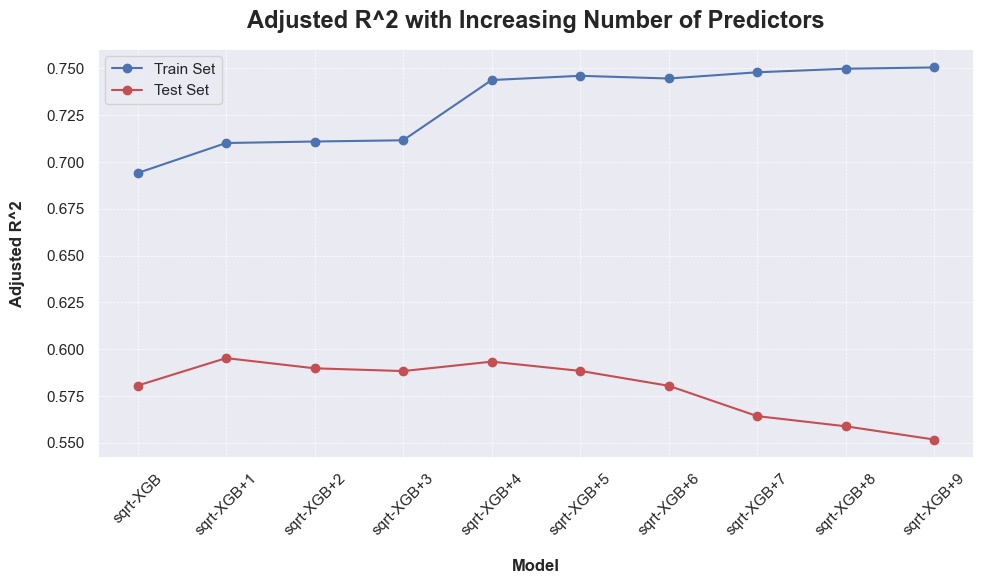

In [44]:
# Extracting model names and adjusted R^2 values
models = train_test_comparison_df.index.tolist()
adjusted_r2_values_tr = train_test_comparison_df['adjusted_train_r2'].tolist()
adjusted_r2_values_te = train_test_comparison_df['adjusted_test_r2'].tolist()

plt.figure(figsize=(10, 6))
plt.plot(models, adjusted_r2_values_tr, marker='o', linestyle='-', color='b', label='Train Set')
plt.plot(models, adjusted_r2_values_te, marker='o', linestyle='-', color='r', label='Test Set')
plt.title('Adjusted R^2 with Increasing Number of Predictors', fontsize=17,  weight='bold', pad=15)
plt.xlabel('Model', labelpad=15, weight='bold', fontsize=12)
plt.ylabel('Adjusted R^2', labelpad=15, weight='bold', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

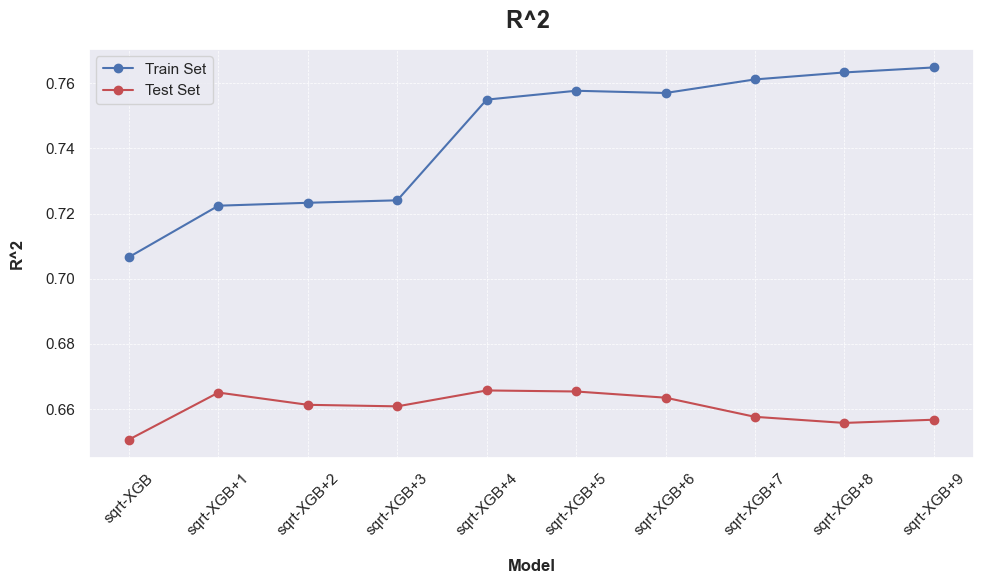

In [45]:
# Extracting model names and adjusted R^2 values
models = train_test_comparison_df.index.tolist()
r2_values_tr = train_test_comparison_df['train_r2'].tolist()
r2_values_te = train_test_comparison_df['test_r2'].tolist()

plt.figure(figsize=(10, 6))
plt.plot(models, r2_values_tr, marker='o', linestyle='-', color='b', label='Train Set')
plt.plot(models, r2_values_te, marker='o', linestyle='-', color='r', label='Test Set')
plt.title('R^2 ', fontsize=17,  weight='bold', pad=15)
plt.xlabel('Model', labelpad=15, weight='bold', fontsize=12)
plt.ylabel('R^2', labelpad=15, weight='bold', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

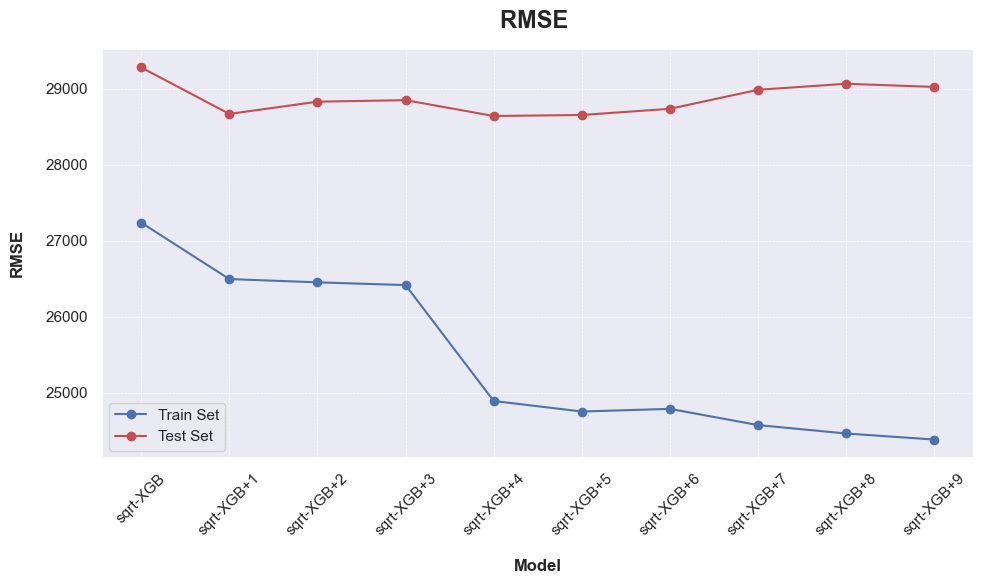

In [46]:
# Extracting model names and adjusted R^2 values
models = train_test_comparison_df.index.tolist()
rmse_values_tr = train_test_comparison_df['train_rmse'].tolist()
rmse_values_te = train_test_comparison_df['test_rmse'].tolist()

plt.figure(figsize=(10, 6))
plt.plot(models, rmse_values_tr, marker='o', linestyle='-', color='b', label='Train Set')
plt.plot(models, rmse_values_te, marker='o', linestyle='-', color='r', label='Test Set')
plt.title('RMSE ', fontsize=17,  weight='bold', pad=15)
plt.xlabel('Model', labelpad=15, weight='bold', fontsize=12)
plt.ylabel('RMSE', labelpad=15, weight='bold', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

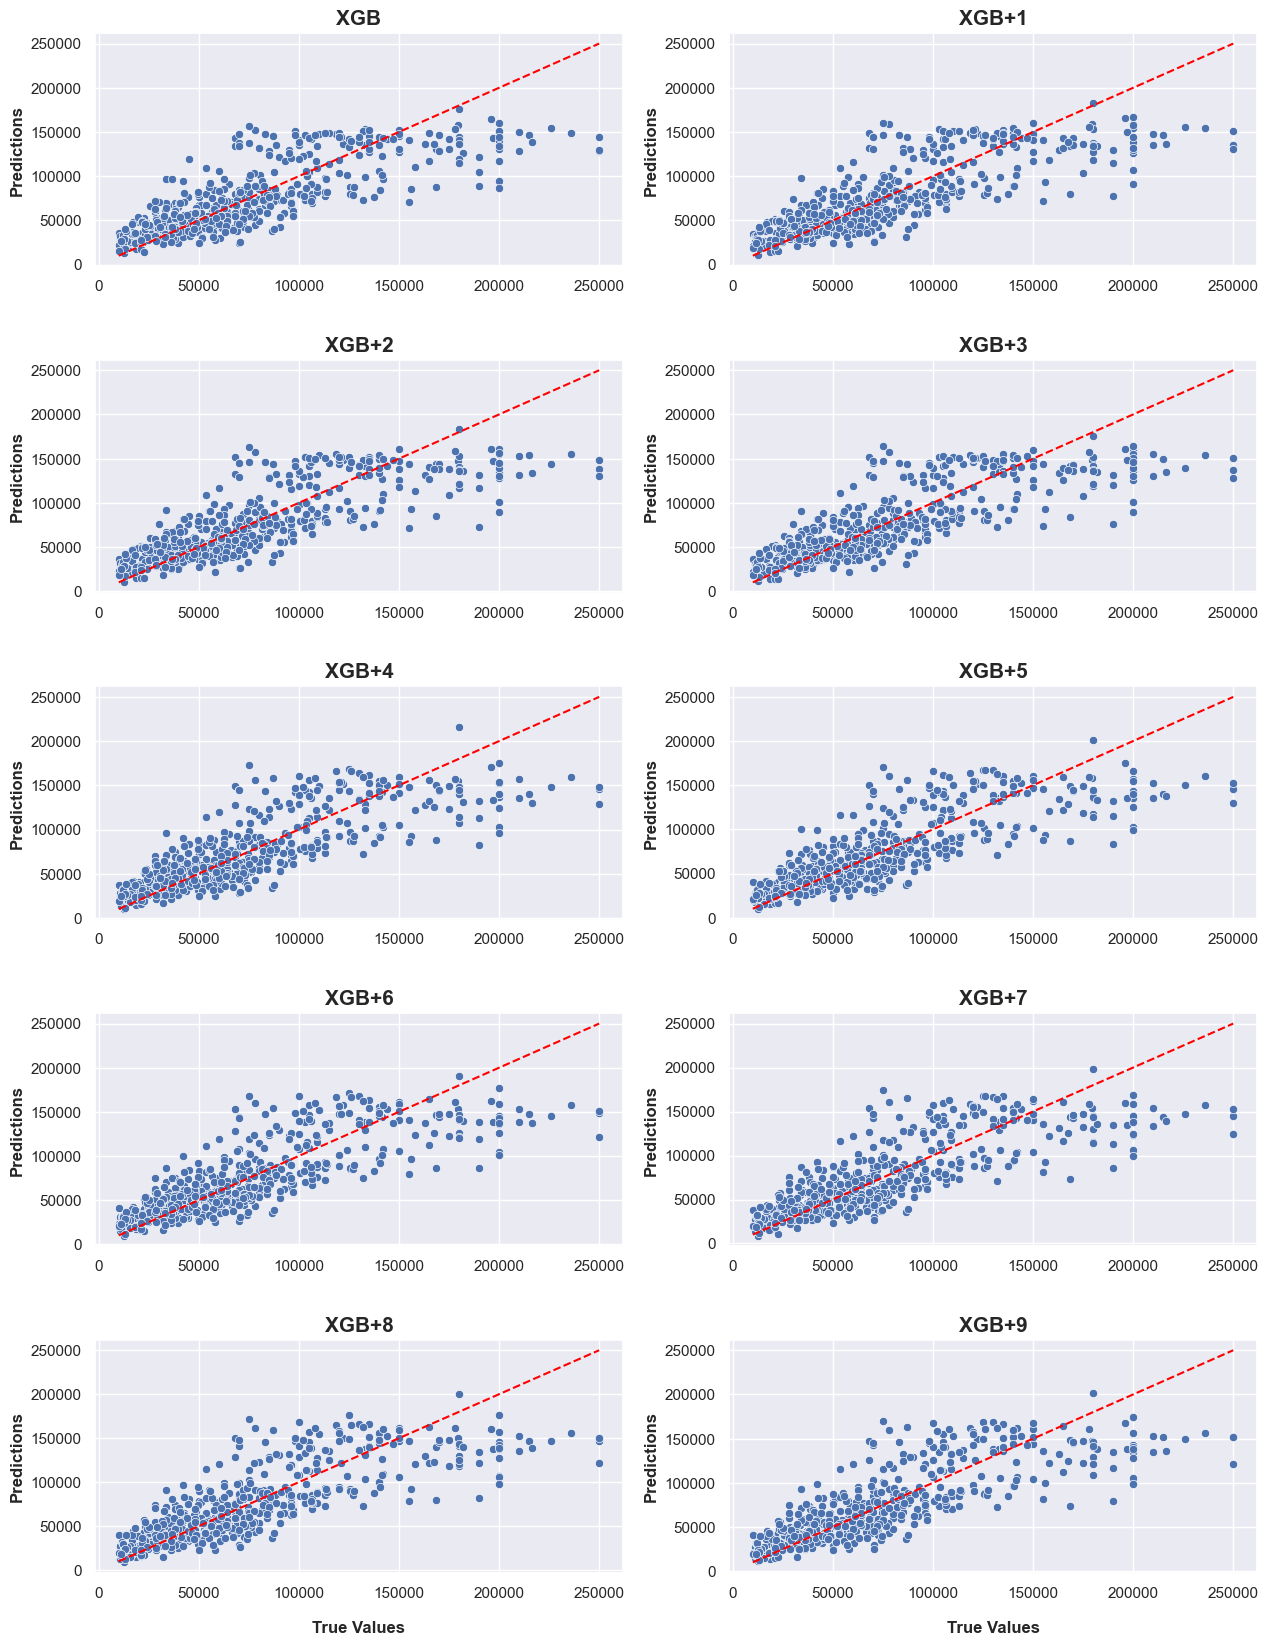

In [47]:
model_names = ["XGB", "XGB+1", "XGB+2", "XGB+3", 
               "XGB+4", "XGB+5", "XGB+6", "XGB+7", 
               "XGB+8", "XGB+9"]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.scatterplot(x=y_test, y=y_test_pred, ax=axs[i])
    axs[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    axs[i].set_title(f'{model}', weight='bold', fontsize=15)
    
    if model in ["XGB+8", "XGB+9"]:
        axs[i].set_xlabel('True Values', weight='bold', fontsize=12, labelpad=15)
    else:
        axs[i].set_xlabel('')
    
    axs[i].set_ylabel('Predictions', weight='bold', fontsize=12)

plt.subplots_adjust(hspace=0.4)
plt.savefig("../../paper/models/all-models-performance.pdf")
plt.show()

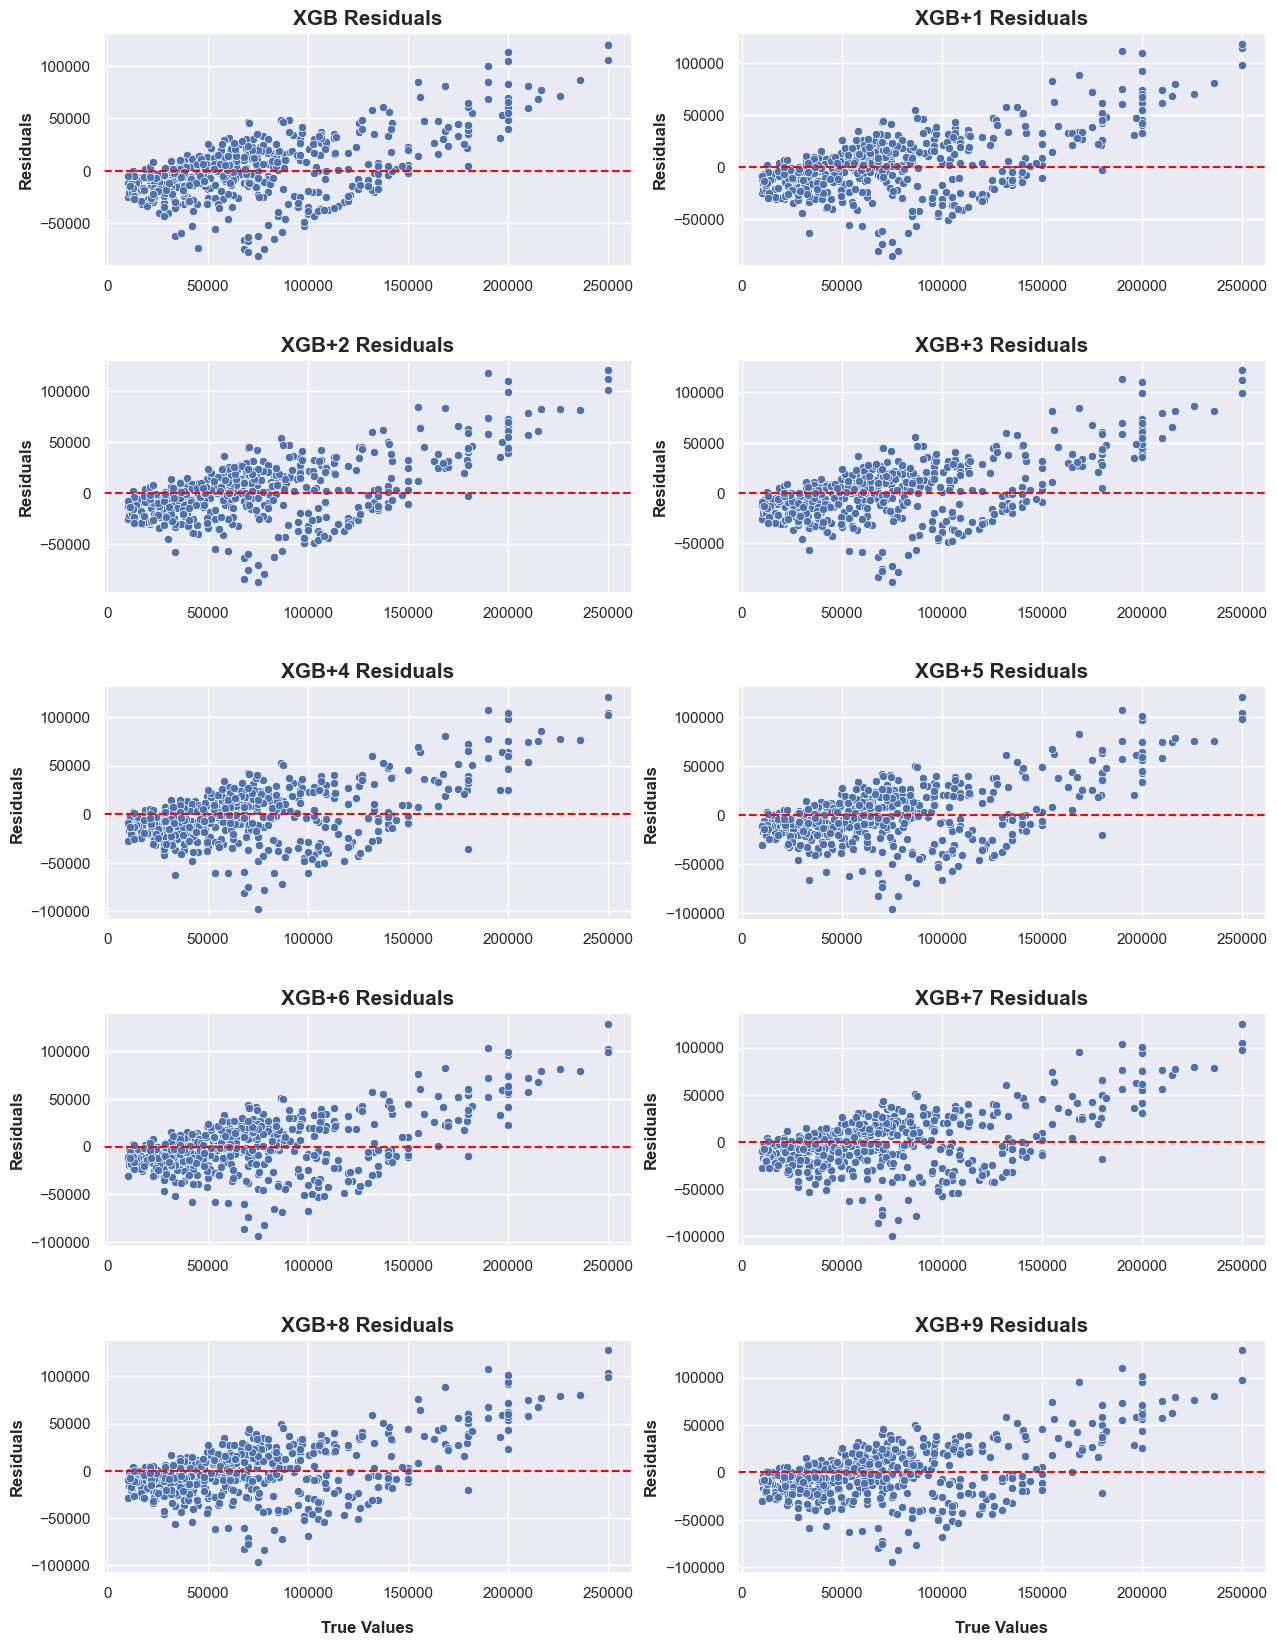

In [48]:
model_names = ["XGB", "XGB+1", "XGB+2", "XGB+3", 
               "XGB+4", "XGB+5", "XGB+6", "XGB+7", 
               "XGB+8", "XGB+9"]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    residuals = y_test - y_test_pred
    
    sns.scatterplot(x=y_test, y=residuals, ax=axs[i])
    axs[i].axhline(y=0, color='red', linestyle='--')  # Línea horizontal en 0 para los residuales
    axs[i].set_title(f'{model} Residuals', weight='bold', fontsize=15)
    
    if model in ["XGB+8", "XGB+9"]:
        axs[i].set_xlabel('True Values', weight='bold', fontsize=12, labelpad=15)
    else:
        axs[i].set_xlabel('')
    
    axs[i].set_ylabel('Residuals', weight='bold', fontsize=12)

plt.subplots_adjust(hspace=0.4)
plt.savefig("../../paper/models/all-models-residuals.pdf")
plt.show()


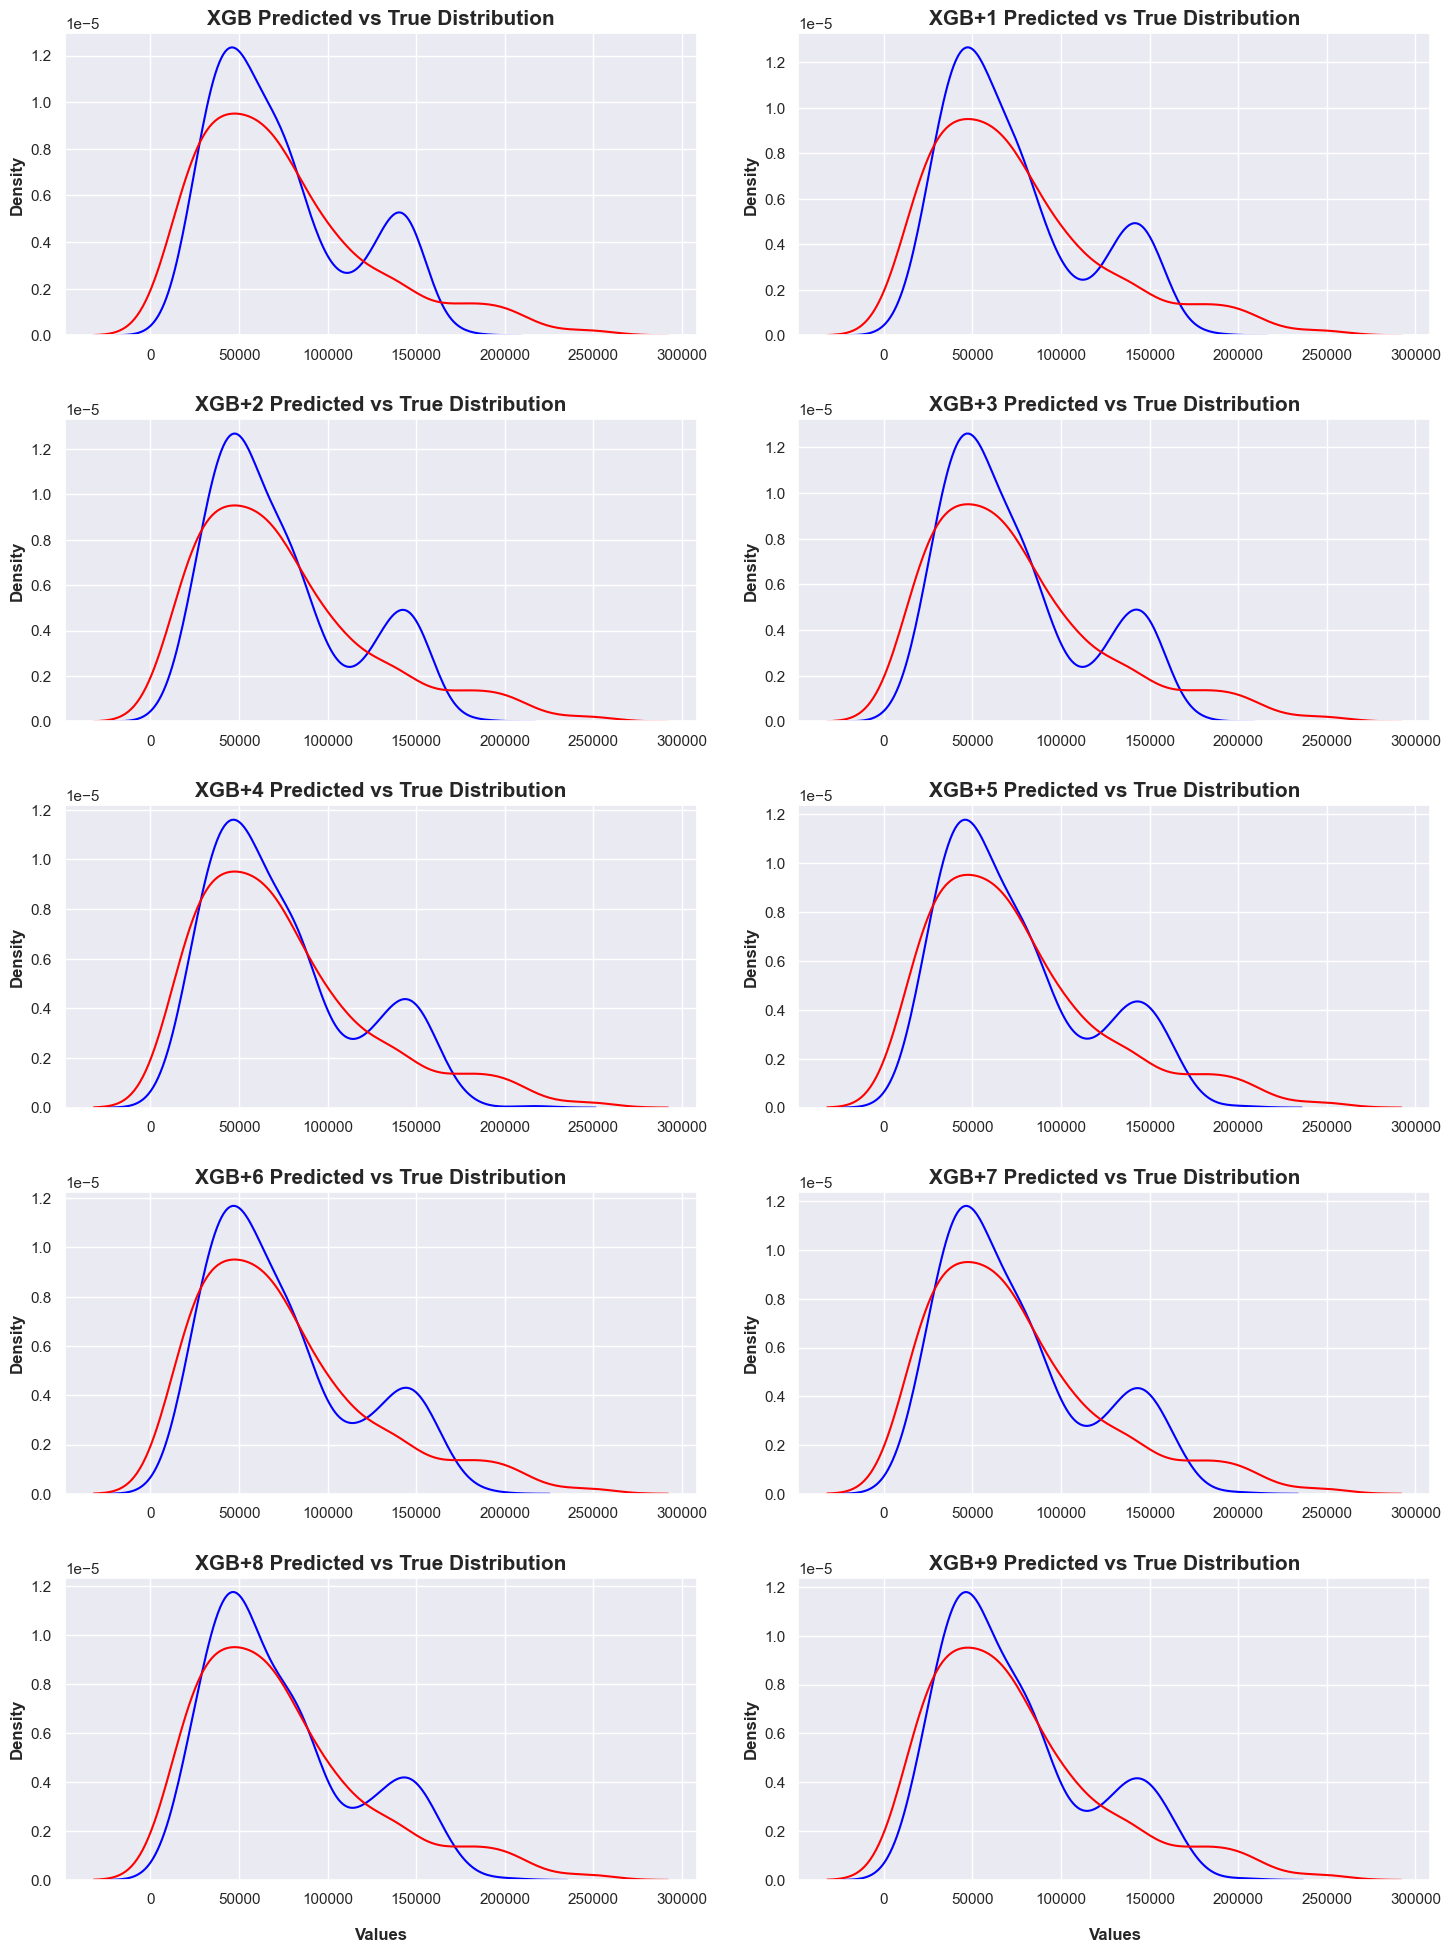

In [49]:
model_names = ["XGB", "XGB+1", "XGB+2", "XGB+3", 
               "XGB+4", "XGB+5", "XGB+6", "XGB+7", 
               "XGB+8", "XGB+9"]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.kdeplot(x=y_test_pred, color='blue', label='Predicted Values', ax=axs[i])
    sns.kdeplot(x=y_test, color='red', label='True Values', ax=axs[i])
    axs[i].set_title(f'{model} Predicted vs True Distribution', weight='bold', fontsize=15)
    
    if model in ["XGB+8", "XGB+9"]:
        axs[i].set_xlabel('Values', weight='bold', fontsize=12, labelpad=15)
    else:
        axs[i].set_xlabel('')
    
    axs[i].set_ylabel('Density', weight='bold', fontsize=12)

plt.tight_layout(pad=2.0)
plt.savefig("../../paper/models/all-models-kde.pdf")
plt.show()

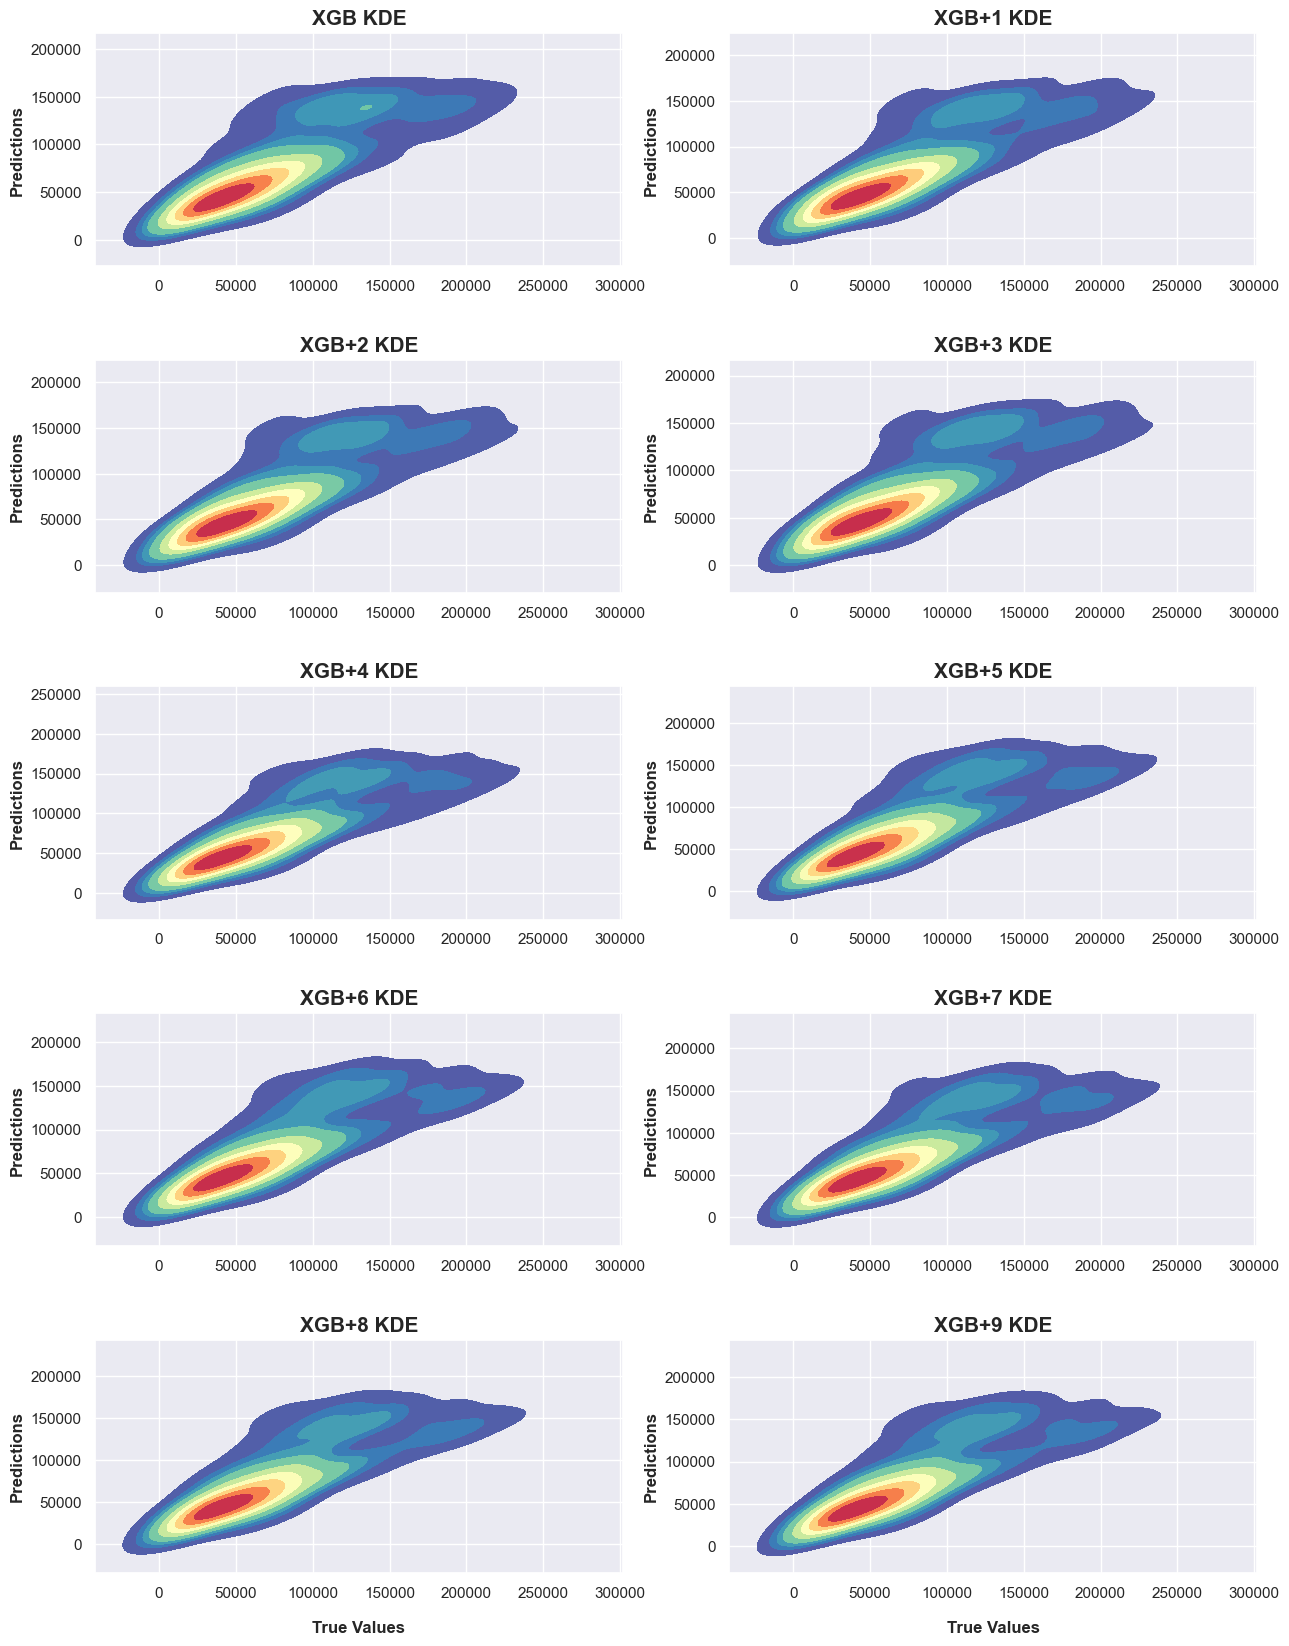

In [50]:
model_names = ["XGB", "XGB+1", "XGB+2", "XGB+3", 
               "XGB+4", "XGB+5", "XGB+6", "XGB+7", 
               "XGB+8", "XGB+9"]

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.kdeplot(x=y_test, y=y_test_pred, fill=True, ax=axs[i], cmap="Spectral_r")
    
    axs[i].set_title(f'{model} KDE', weight='bold', fontsize=15)
    
    if model in ["XGB+8", "XGB+9"]:
        axs[i].set_xlabel('True Values', weight='bold', fontsize=12, labelpad=15)
    else:
        axs[i].set_xlabel('')
    
    axs[i].set_ylabel('Predictions', weight='bold', fontsize=12)

plt.subplots_adjust(hspace=0.4)
plt.savefig("../../paper/models/all-models-kde.pdf")
plt.show()

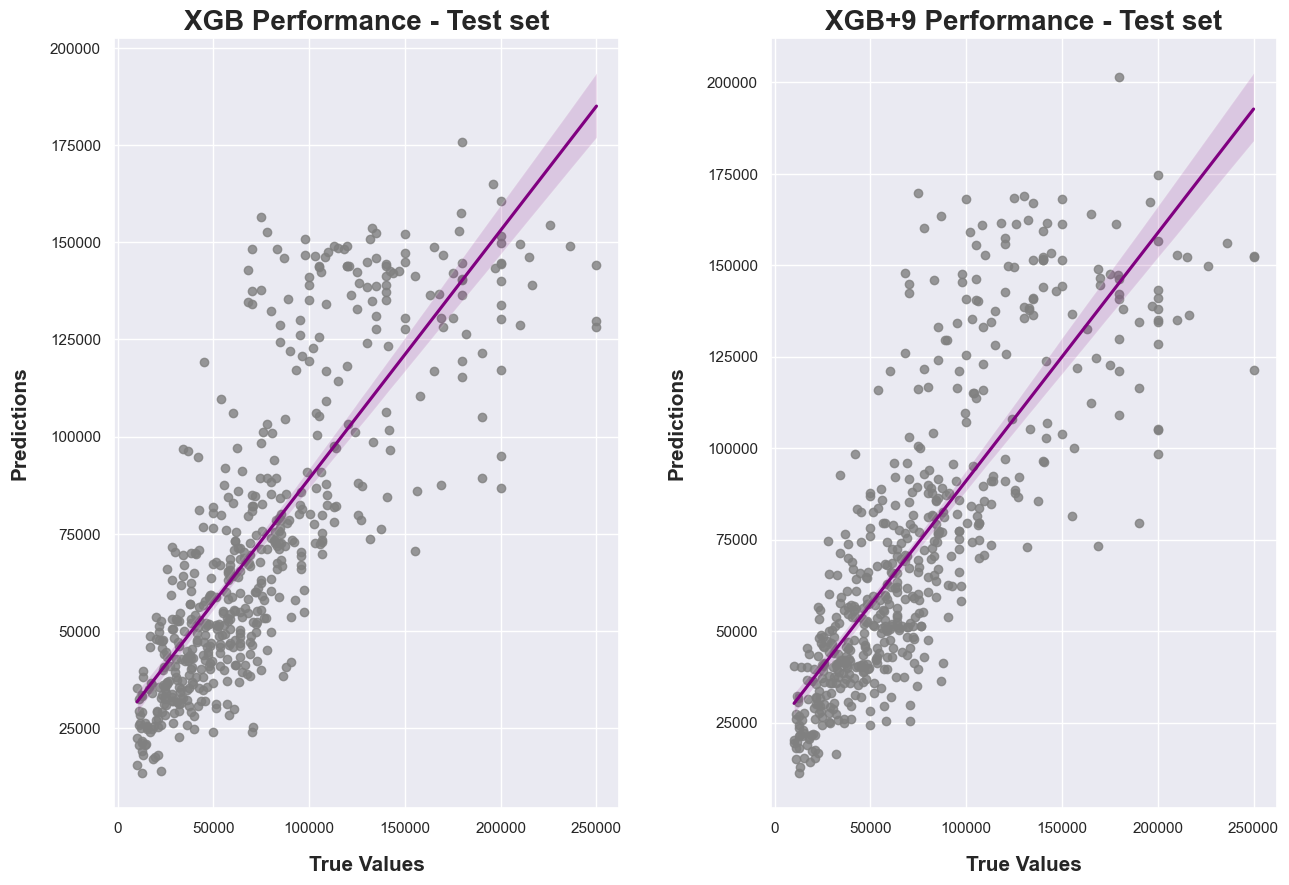

In [51]:
model_names = ["XGB", "XGB+9"]

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.3)  # Ajusta el espacio entre las gráficas

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.regplot(x=y_test, y=y_test_pred, ax=axs[i], 
                line_kws={'color':'purple'}, scatter_kws={'color':'grey'})
    
    axs[i].set_title(f'{model} Performance - Test set', weight='bold', fontsize=20)
    axs[i].set_xlabel('True Values', fontsize=15, weight='bold', labelpad=15)
    axs[i].set_ylabel('Predictions', fontsize=15, weight='bold', labelpad=15)
    
plt.savefig("../../paper/models/comparison-test-predictions.pdf")
plt.show()

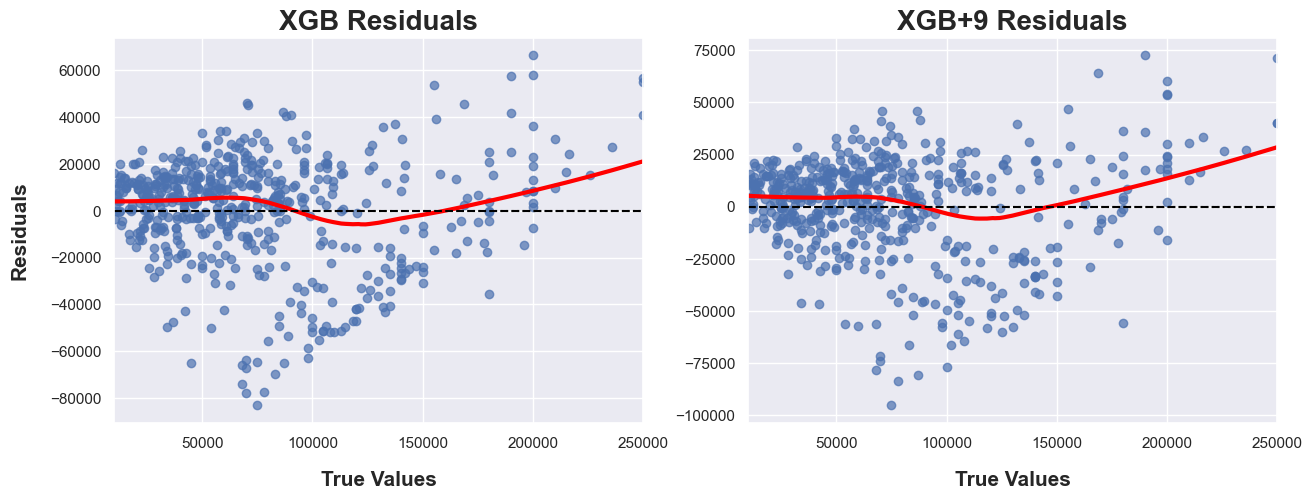

In [52]:
model_names = ["XGB", "XGB+9"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.2)  

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    residuals = y_test - y_test_pred
    
    sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 3}, ax=axs[i], scatter_kws={'alpha': 0.7})
    axs[i].axhline(y=0, color='black', linestyle='--')
    axs[i].set_title(f'{model} Residuals', weight='bold', fontsize=20)
    axs[i].set_xlabel('True Values', fontsize=15, weight='bold', labelpad=15)
    
    if i == 0:
        axs[i].set_ylabel('Residuals', fontsize=15, weight='bold', labelpad=15)
    else:
        axs[i].set_ylabel('')  
    
plt.savefig("../../paper/models/comparison-residuals.pdf")
plt.show()

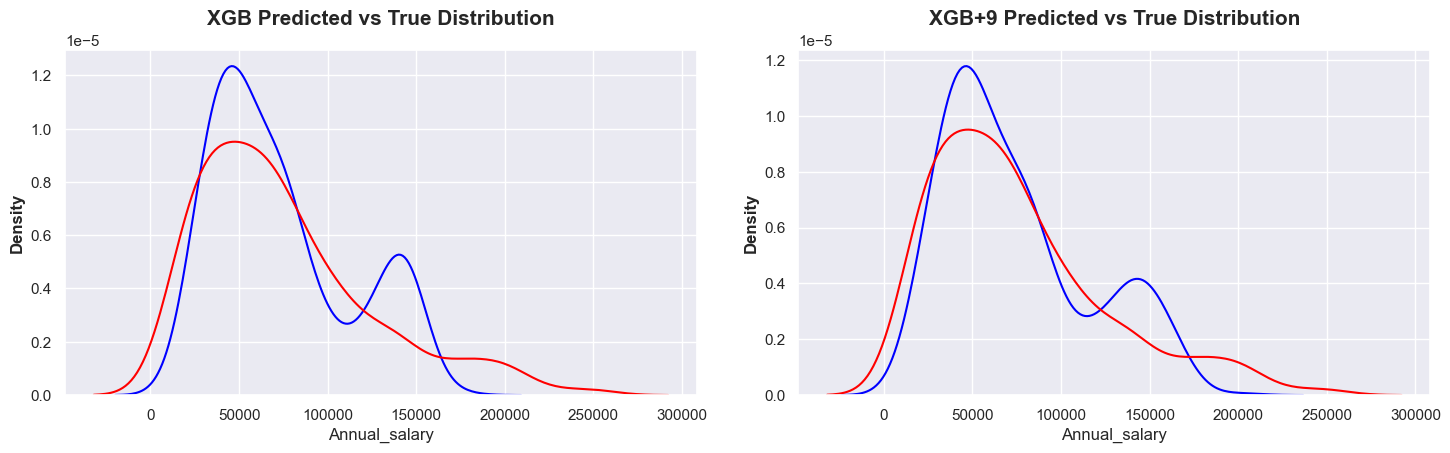

In [53]:
model_names = ["XGB","XGB+9"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.kdeplot(x=y_test_pred, color='blue', label='Predicted Values', ax=axs[i])
    sns.kdeplot(x=y_test, color='red', label='True Values', ax=axs[i])
    axs[i].set_title(f'{model} Predicted vs True Distribution', weight='bold', fontsize=15, pad=18)
    
    axs[i].set_ylabel('Density', weight='bold', fontsize=12)

plt.tight_layout(pad=2.0)
plt.savefig("../../paper/models/all-models-kde.pdf")
plt.show()

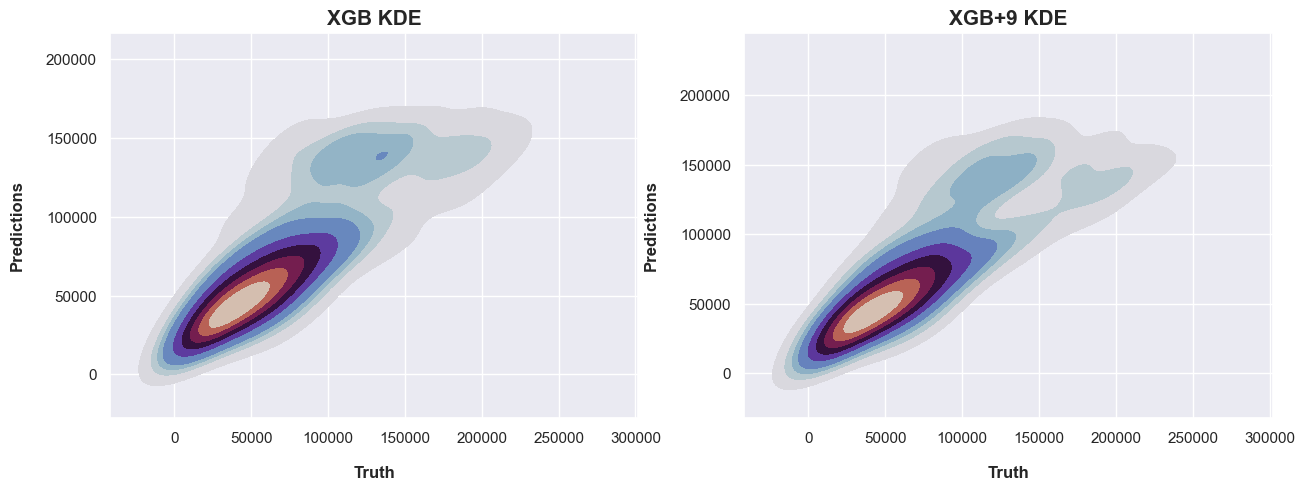

In [54]:
model_names = ["XGB","XGB+9"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.ravel()

for i, model in enumerate(model_names):
    y_test_pred = np.loadtxt(f"../../output/sqrt-{model}-test-predictions.csv", delimiter=",")
    
    sns.kdeplot(x=y_test, y=y_test_pred, fill=True, ax=axs[i], cmap="twilight")
    
    axs[i].set_title(f'{model} KDE', weight='bold', fontsize=15)
    axs[i].set_xlabel('Truth', weight='bold', fontsize=12, labelpad=15)
    axs[i].set_ylabel('Predictions', weight='bold', fontsize=12, labelpad=15)

plt.subplots_adjust(hspace=0.4)
plt.savefig("../../paper/models/all-models-kde.pdf")
plt.show()